# Stitching.ipynb

### Ryan Servera (260741736)

# 2 Image Stitching

## 2.1 Coding Questions

## 1. Compute SIFT keypoints and corresponding descriptors for images 1Hill and 2Hill

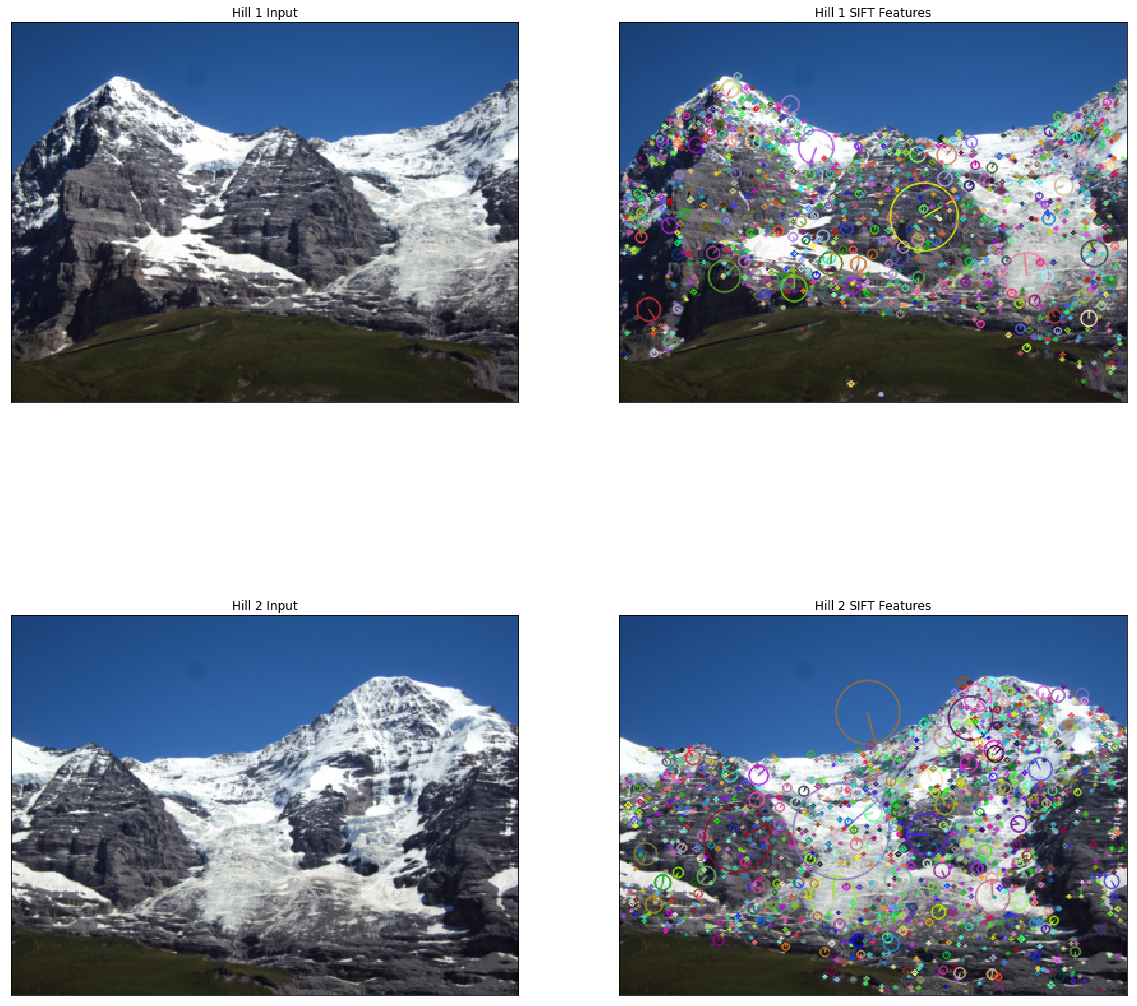

In [10]:
# Useful imports 
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read images to stitch
hill1 = cv2.imread("./stitching_images/1Hill.JPG")
hill2 = cv2.imread("./stitching_images/2Hill.JPG")

hill1 = cv2.cvtColor(hill1, cv2.COLOR_BGR2RGB)
hill2 = cv2.cvtColor(hill2, cv2.COLOR_BGR2RGB)

hill1 = hill1[1: hill1.shape[0] - 1, 1:hill1.shape[1] - 1, :]
hill2 = hill2[1: hill2.shape[0] - 1, 1:hill2.shape[1] - 1, :]

# Make copies of images to stitch
hill1_copy = hill1.copy()
hill2_copy = hill2.copy()

# Compute keypoints and descriptors for both hill images using SIFT
sift_obj = cv2.xfeatures2d.SIFT_create()
keypoints_hill1, descriptors_hill1 = sift_obj.detectAndCompute(hill1, None)
keypoints_hill2, descriptors_hill2 = sift_obj.detectAndCompute(hill2, None)

# Draw the keypoints of the images
cv2.drawKeypoints(hill1, keypoints_hill1, hill1_copy, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2.drawKeypoints(hill2, keypoints_hill2, hill2_copy, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Plot the SIFT features for each hill
plt.figure(figsize=(20,20))
plt.subplot(221), plt.imshow(hill1)
plt.title("Hill 1 Input"), plt.xticks([]), plt.yticks([])
plt.subplot(222), plt.imshow(hill1_copy)
plt.title("Hill 1 SIFT Features"), plt.xticks([]), plt.yticks([])
plt.subplot(223), plt.imshow(hill2)
plt.title("Hill 2 Input"), plt.xticks([]), plt.yticks([])
plt.subplot(224), plt.imshow(hill2_copy)
plt.title("Hill 2 SIFT Features"), plt.xticks([]), plt.yticks([])
plt.show()

## 2. Find matching keypoints in two images and display the 20 best pairs.

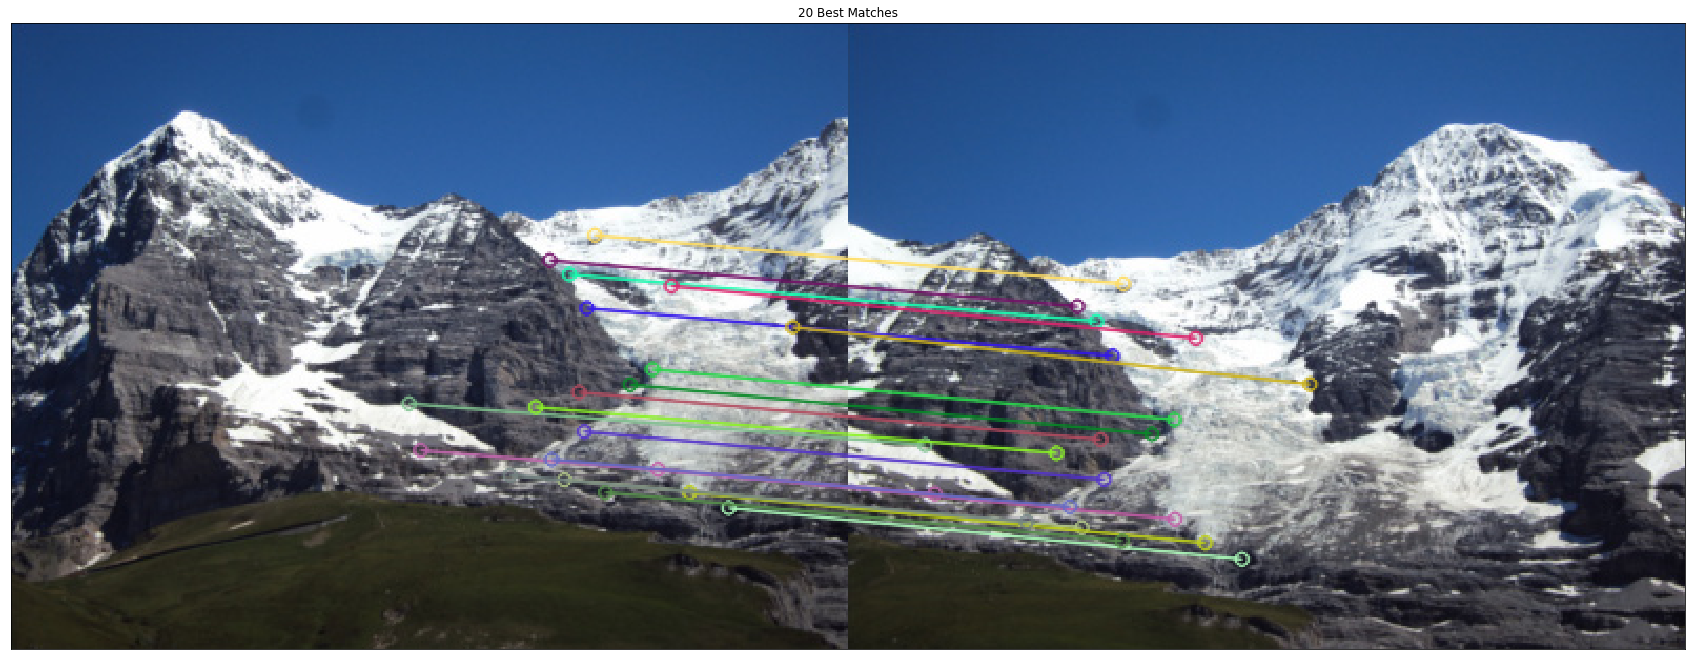

In [2]:
# Instantiate BFMatcher object
bf = cv2.BFMatcher()

# Find all the descriptor matches
matches = bf.match(descriptors_hill1,descriptors_hill2)

# Sort all the matches
matches = sorted(matches, key = lambda x:x.distance)

# Draw the 20 best matches
imgmatch = cv2.drawMatches(hill1, keypoints_hill1, hill2, keypoints_hill2, matches[:20], hill1, flags=2)

# Plot the 20 best matches
plt.figure(figsize=(30,30))
plt.title("20 Best Matches"), plt.xticks([]), plt.yticks([])
plt.imshow(imgmatch)
plt.show()

## 3. Find homography using RANSAC method and apply transformation to 1Hill. Image 2Hill should not be transformed.

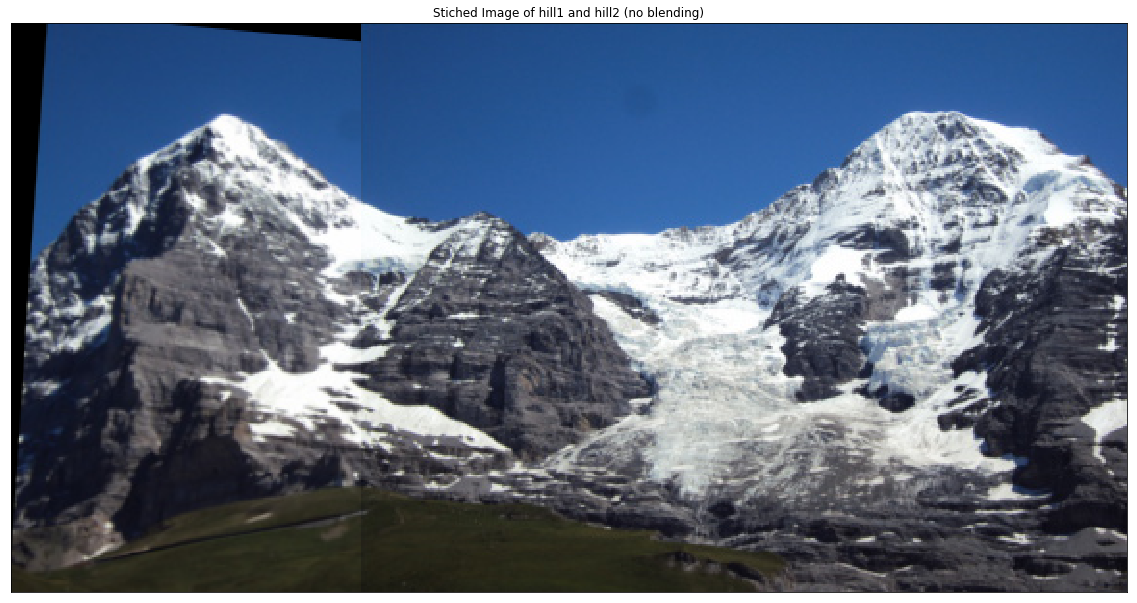

In [3]:
# Arrange matching keypoints, for hill1 and hill2, in two lists
GoodMatches = []
for i, m in enumerate(matches):
    GoodMatches.append((m.trainIdx, m.queryIdx))
    
mpr = np.float32([keypoints_hill2[i].pt for (i,__) in GoodMatches])
mpl = np.float32([keypoints_hill1[i].pt for (__, i) in GoodMatches])

# Linear shift one of the images
for i in mpr:
    i[0] += hill2.shape[1]
    
# find homography and warped image accordingly (using RANSAC method)
H, __ = cv2.findHomography(mpl, mpr, cv2.RANSAC, 4)
wimg = cv2.warpPerspective(hill1, H, (hill1.shape[1]+hill2.shape[1],hill1.shape[0]))

# Make a copy of the warped hill1 image
warped_hill1 = wimg.copy()

wimg[:, 398:,:] = hill2

# Crop the image
cropped_image1 = wimg[2:, 216:, :]

# Plot the stiched 1Hill and 2Hill image without blending
plt.figure(figsize=(20,20))
plt.title("Stiched Image of hill1 and hill2 (no blending)"), plt.xticks([]), plt.yticks([])
plt.imshow(cropped_image1)
plt.show()

## 4. Stitch transformed 1Hill and original 2Hill together using pyramid image blending.

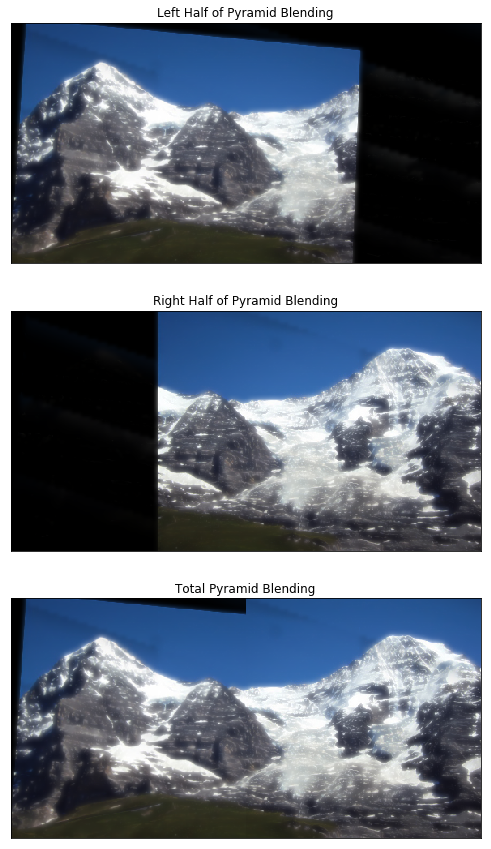

In [5]:
# Load and crop warped hill2 image
A = warped_hill1
A = warped_hill1[2: , 216:, :]

# Load and crop hill1
B = np.zeros([wimg.shape[0],wimg.shape[1] ,3],dtype=np.uint8)
B[:, 398:, :] = hill2 
B = B[2:, 216: ,:]

g_size = 255  # gaussian mask blur size
depth = 3  # pyramid depth size

row, col, dpt = A.shape
# generate Gaussian pyramid for imgA
G = A.copy()
gp1 = [G]
for i in range(depth):
    G = cv2.pyrDown(G)
    gp1.append(G)
    
# generate Gaussian pyramid for imgB
G = B.copy()
gp2 = [G]
for i in range(depth):
    G = cv2.pyrDown(G)
    gp2.append(G)

# generate Laplacian pyramid for imgA
lp1 = [gp1[depth-1]]  # store last gaussian image for top of lp pyramid
for i in range(depth-1,0,-1):
    # upsample lower pyramid
    hr = cv2.pyrUp(gp1[i], dstsize=(gp1[i-1].shape[1], gp1[i-1].shape[0]))
    lp = cv2.subtract(gp1[i-1], hr, cv2.CV_32F)  # subtract different levels
    lp1.append(lp)

# generate Laplacian pyramid for imgB
lp2 = [gp2[depth-1]]  # store last gaussian image for top of lp pyramid
for i in range(depth-1,0,-1):
    # upsample lower pyramid
    hr = cv2.pyrUp(gp2[i], dstsize=(gp2[i-1].shape[1], gp2[i-1].shape[0]))
    lp = cv2.subtract(gp2[i-1], hr, cv2.CV_32F)  # subtract different levels
    lp2.append(lp)

# add left and right halves of images in each level
LP = []
for la, lb in zip(lp1, lp2):
    row, cols, dpt = la.shape
    # stack columns (half and half)
    lp = np.hstack((la[:, :round(cols/2)], lb[:, round(cols/2):]))
    LP.append(lp)

# build Gaussian pyramid from selected region
mask = np.zeros((A.shape[1], A.shape[0]))
# create mask
mask[:, round(A.shape[1]/2):] = 1
# blur mask
mask = cv2.GaussianBlur(mask, (g_size, g_size), 0)
# generate Gaussian pyramid
G = mask.copy()
GR = [G]
for i in range(depth):
    G = cv2.pyrDown(G)
    GR.append(G)

# add left and right halves of images in each level using Gaussian mask
LP_mask = []
i = 1
for la, lb in zip(lp1, lp2):
    idx = depth - i

    # Now blend
    lp = (1-GR[idx].reshape(GR[idx].shape[1],GR[idx].shape[0],1)) * la + \
         GR[idx].reshape(GR[idx].shape[1],GR[idx].shape[0],1) * lb
    lp = np.uint8(lp)  # convert back to uint8
    LP_mask.append(lp)
    i += 1

# now reconstruct
rs = LP[0]
for i in range(1, depth):
    rs = cv2.pyrUp(rs)  # upsample current lp image
    rs = cv2.add(rs, LP[i])  # add lp image

# now Gaussian mask reconstruct
rs_mask = LP_mask[0]
for i in range(1, depth):
    rs_mask = cv2.pyrUp(rs_mask)  # upsample current lp image
    rs_mask = cv2.add(rs_mask, LP_mask[i])  # add lp image
    
    
    
    
# Save the left half of the pyramid blend
left = rs_mask




# Reverse the inputs
B = warped_hill1
B = warped_hill1[2: , 216:, :]
A = np.zeros([wimg.shape[0],wimg.shape[1] ,3],dtype=np.uint8)
A[:, 398:, :] = hill2 
A = A[2:, 216: ,:]

g_size = 255  # gaussian mask blur size
depth = 3  # pyramid depth size

row, col, dpt = A.shape
# generate Gaussian pyramid for imgA
G = A.copy()
gp1 = [G]
for i in range(depth):
    G = cv2.pyrDown(G)
    gp1.append(G)

# generate Gaussian pyramid for imgB
G = B.copy()
gp2 = [G]
for i in range(depth):
    G = cv2.pyrDown(G)
    gp2.append(G)

# generate Laplacian pyramid for imgA
lp1 = [gp1[depth-1]]  # store last gaussian image for top of lp pyramid
for i in range(depth-1,0,-1):
    # upsample lower pyramid
    hr = cv2.pyrUp(gp1[i], dstsize=(gp1[i-1].shape[1], gp1[i-1].shape[0]))
    lp = cv2.subtract(gp1[i-1], hr, cv2.CV_32F)  # subtract different levels
    lp1.append(lp)

# generate Laplacian pyramid for imgB
lp2 = [gp2[depth-1]]  # store last gaussian image for top of lp pyramid
for i in range(depth-1,0,-1):
    # upsample lower pyramid
    hr = cv2.pyrUp(gp2[i], dstsize=(gp2[i-1].shape[1], gp2[i-1].shape[0]))
    lp = cv2.subtract(gp2[i-1], hr, cv2.CV_32F)  # subtract different levels
    lp2.append(lp)

# add left and right halves of images in each level
LP = []
for la, lb in zip(lp1, lp2):
    row, cols, dpt = la.shape
    # stack columns (half and half)
    lp = np.hstack((la[:, :round(cols/2)], lb[:, round(cols/2):]))
    LP.append(lp)

# build Gaussian pyramid from selected region
mask = np.zeros((A.shape[1], A.shape[0]))
# create mask
mask[:, round(A.shape[1]/2):] = 1
# blur mask
mask = cv2.GaussianBlur(mask, (g_size, g_size), 0)
# generate Gaussian pyramid
G = mask.copy()
GR = [G]
for i in range(depth):
    G = cv2.pyrDown(G)
    GR.append(G)

# add left and right halves of images in each level using Gaussian mask
LP_mask = []
i = 1
for la, lb in zip(lp1, lp2):
    idx = depth - i

    # Now blend
    lp = (1-GR[idx].reshape(GR[idx].shape[1],GR[idx].shape[0],1)) * la + \
         GR[idx].reshape(GR[idx].shape[1],GR[idx].shape[0],1) * lb
    lp = np.uint8(lp)  # convert back to uint8
    LP_mask.append(lp)
    i += 1

# now reconstruct
rs = LP[0]
for i in range(1, depth):
    rs = cv2.pyrUp(rs)  # upsample current lp image
    rs = cv2.add(rs, LP[i])  # add lp image

# now Gaussian mask reconstruct
rs_mask = LP_mask[0]
for i in range(1, depth):
    rs_mask = cv2.pyrUp(rs_mask)  # upsample current lp image
    rs_mask = cv2.add(rs_mask, LP_mask[i])  # add lp image
    

# Save the right half of the pyramid shift    
right = rs_mask


# Stich the two halves together
final_pyramid = np.hstack((left[:, :round(right.shape[1]/2)], right[:, round(right.shape[1]/2):]))

# display results
plt.figure(figsize=(15,15))
plt.subplot(311), plt.imshow(left)
plt.title('Left Half of Pyramid Blending'), plt.xticks([]), plt.yticks([])
plt.subplot(312), plt.imshow(right)
plt.title('Right Half of Pyramid Blending'), plt.xticks([]), plt.yticks([])
plt.subplot(313), plt.imshow(final_pyramid)
plt.title('Total Pyramid Blending'), plt.xticks([]), plt.yticks([])
plt.show()


## 5. Compute SURF keypoints and corresponding descriptors for images 12Hill and 3Hill.

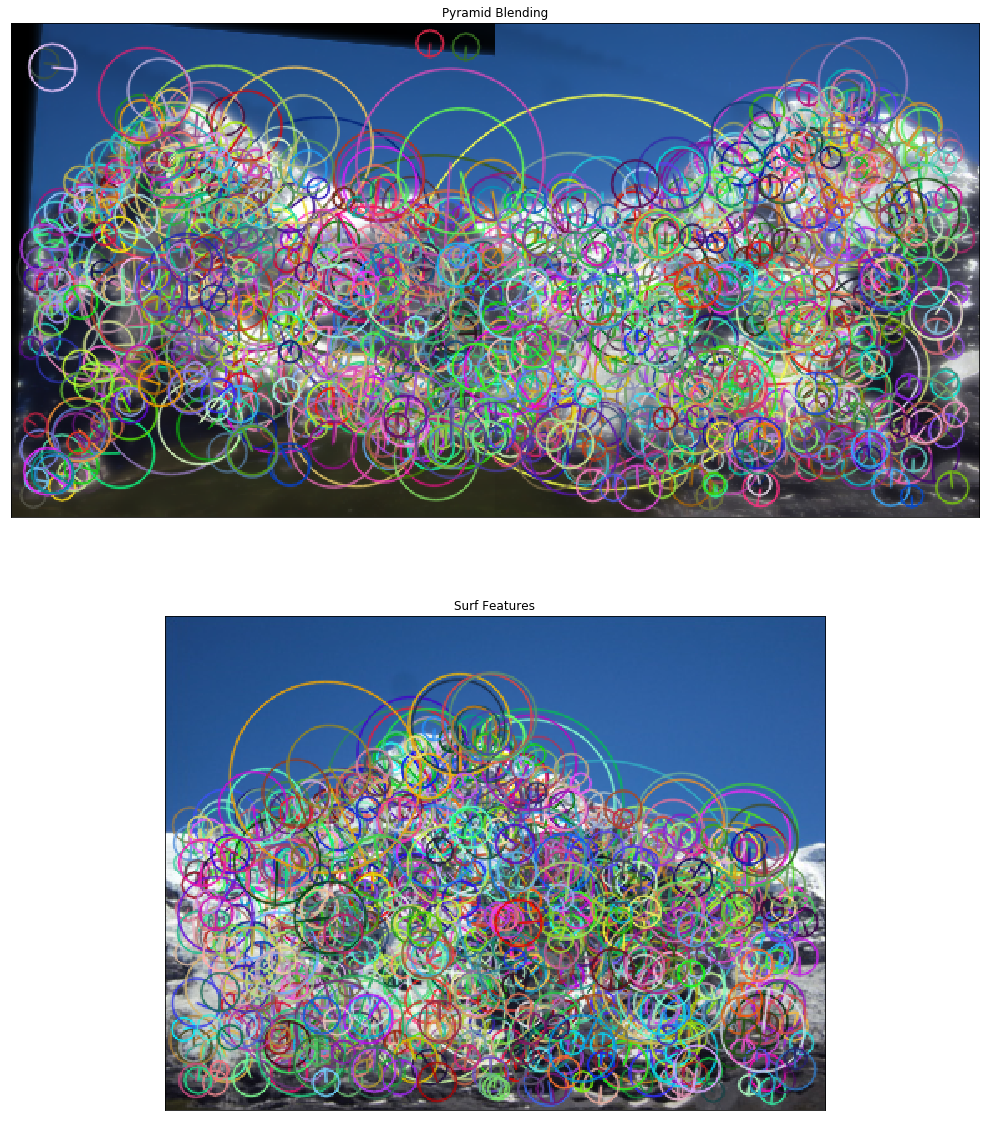

In [6]:
# Read images to stitch
hill12 = final_pyramid
hill3 = cv2.imread("./stitching_images/3Hill.JPG")

hill3 = cv2.cvtColor(hill3, cv2.COLOR_BGR2RGB)

hill3 = hill3[1: hill3.shape[0] - 1, 1:hill3.shape[1] - 1, :]

# Makes copies of images to stitch
hill12_copy = cropped_image1.copy()
hill3_copy = hill3.copy()

# Instantiate a SURF object
surf_obj = cv2.xfeatures2d.SURF_create()

# Compute keypoints and descriptors for both hill images using SURF
keypoints_hill3, descriptors_hill3 = surf_obj.detectAndCompute(hill3, None)
keypoints_hill12, descriptors_hill12 = surf_obj.detectAndCompute(hill12, None)

# Draw the keypoints of the images
cv2.drawKeypoints(hill3, keypoints_hill3, hill3_copy, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2.drawKeypoints(hill12, keypoints_hill12, hill12_copy, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Plot the SURF features for each hill
plt.figure(figsize=(20,20))
plt.subplot(211), plt.imshow(hill12_copy)
plt.title('Pyramid Blending'), plt.xticks([]), plt.yticks([])
plt.subplot(212), plt.imshow(hill3_copy)
plt.title("Surf Features"), plt.xticks([]), plt.yticks([])
plt.show()

## 6. Find matching keypoints in two images and display the 20 best pairs.

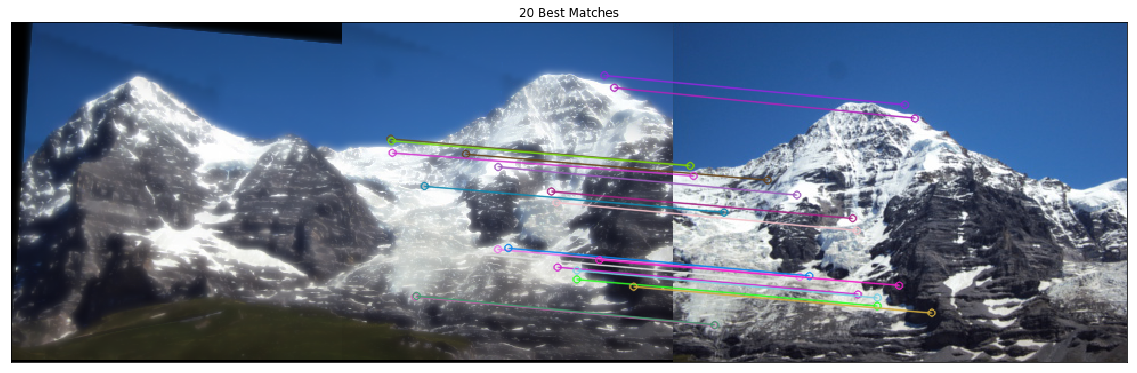

In [7]:
# Find all the descriptor matches
matches1 = bf.match(descriptors_hill12,descriptors_hill3)

# Sort all the matches
matches1 = sorted(matches1, key = lambda x:x.distance)

# Draw the 20 best matches
imgmatch1 = cv2.drawMatches(hill12, keypoints_hill12, hill3, keypoints_hill3, matches1[:20], hill12, flags=2)

# Plot the 20 best matches
plt.figure(figsize=(20,20))
plt.title("20 Best Matches"), plt.xticks([]), plt.yticks([])
plt.imshow(imgmatch1)
plt.show()

## 7. Find homography using RANSAC method and apply transformation to3Hill. Image 12Hill should not be transformed.

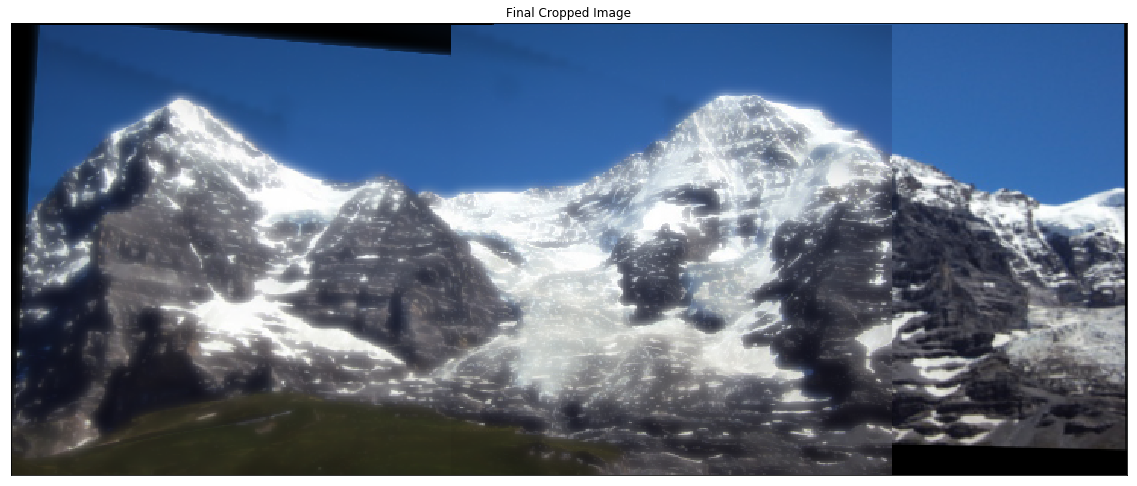

In [8]:
# Arrange matching keypoints, for hill12 and hill3, in two lists
GoodMatches1 = []
for i, m in enumerate(matches1):
    GoodMatches1.append((m.trainIdx, m.queryIdx))
    
mpr = np.float32([keypoints_hill3[i].pt for (i, __) in GoodMatches1])
mpl = np.float32([keypoints_hill12[i].pt for (__ , i) in GoodMatches1])
    
# find homography and wrap image accordingly (using RANSAC method)
H, __ = cv2.findHomography(mpr, mpl, cv2.RANSAC, 4)
wimg1 = cv2.warpPerspective(hill3, H, (hill3.shape[1]+hill12.shape[1],hill3.shape[0]))

# Copy of hill3 warped
warped_hill3 = wimg1.copy()

wimg1[2:, :hill12.shape[1],:] = hill12

# Crop the final stitch
cropped_image_final = wimg1[:, :735 :]

# Plot the stiched 3Hill and Hill12 image without blending
plt.figure(figsize=(20,20))
plt.title("Final Cropped Image"), plt.xticks([]), plt.yticks([])
plt.imshow(cropped_image_final)
plt.show()

## 8. Stitch transformed 3Hill and 12Hill together and apply linear image blending.

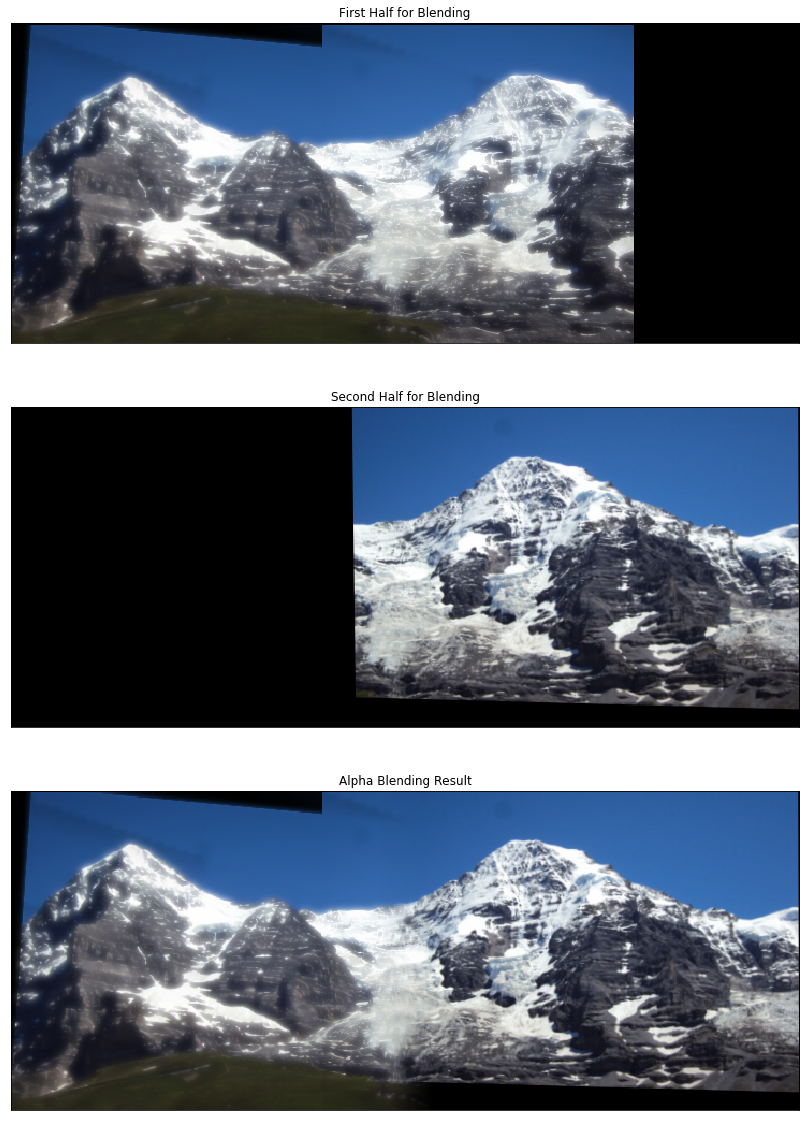

In [9]:
# Load and crop the pyramid blended image
A = np.zeros([cropped_image_final.shape[0], cropped_image_final.shape[1] ,3],dtype=np.uint8)
A[2:, :580, :] = final_pyramid

# Load and crop warped hill3
B = warped_hill3
B = B[:, :735 :]

""" ALPHA BLENDING """
def Ramp(i_width, r_width, r_index, start, end):
    """
    Create alpha blending function
    :param i_width: img width
    :param r_width: ramp width
    :param r_index: center ramp index
    :param start: starting ramp value
    :param end: ending ramp value
    :return:
    """
    a = np.zeros((i_width))
    step = (end - start) / (r_width-1)
    idx = round(r_index - (r_width / 2))  # left side starting index of alpha ramp
    for i in range(r_width):
        a[idx] = start + step*i
        idx += 1
    a[idx:] = 1
    return a

# alpha blending ramp
ramp_size = 50  # alpha blending ramp size
alpha = Ramp(A.shape[1], ramp_size, round(A.shape[1]/2), 0, 1)

# # Now blend
I_blend = (1-alpha.reshape(1,-1,1)) * A + alpha.reshape(1,-1,1)*B # Horizontal is (-1, 1, 1) Vertical is (1, -1 ,1)
I_blend = np.uint8(I_blend)  # convert back to uint8
# Mask = (height, width, channel) in python you only need to refer to one channel and python will make is for all channels

cropped_image_final[:, :I_blend.shape[1], :] = I_blend

# display images
plt.figure(figsize=(20,20))
plt.subplot(311), plt.imshow(A)
plt.title("First Half for Blending"), plt.xticks([]), plt.yticks([])
plt.subplot(312), plt.imshow(B)
plt.title("Second Half for Blending"), plt.xticks([]), plt.yticks([])
plt.subplot(313), plt.imshow(I_blend)
plt.title("Alpha Blending Result"), plt.xticks([]), plt.yticks([])
plt.show()

## 2.2 Reasoning Questions

## 1. What are the differences between SIFT and SURF? Comment on the speed, number of keypoints and density. Support your arguments with statistics.

SURF is 3 to 6 times faster than SIFT, by using integral images and box filter. However, it is less robust to illumination therefore there are more keypoints in SURF than in SIFT, where the density of those keypoints is higher

## 2. Discuss at least two pros and cons of pyramid and linear blending techniques. When should one prefer pyramid blending over linear blending?

Pyramid blending is more complex to implement, but it is better at smoothing low frequency exposure variations and retaining sharp transitions. As opposed to blending which is simpler to implement, but not over smoothed to the point of ghosting. You want to use pyramid blending when there is a large amount of exposure variations.

## 3. What would happen if a random subset of pairs of matching keypoints is used for finding homography?

Depending on how good the matches are then the pairs can potential find a bad homography, if the random points are poor matches. In the end this can lead to a bad warped image

## 4. Discuss the relationship between the number of pairs of matching keypoints used for finding homography and the accuracy of inferred homography.

As there are more matching keypoints used for finding homography each pair has less effect individually on the homography. Therefore, if as there are more and more poor matches introduced the less accurate it is because good matches are not weighted higher than the poor one.